# So overall, this is the same as the binary classifier from the first binary classifier, except we also have shorting as well

In this case, we would be executing  trades risking 2% in total of our capital when to buy and when to short. That way we will also make sure not to loose our total capital in general, and we will also simulate liquidation. Meaning, any other stuff that was updated in the first binary classifier we go over and put it in this classifier as well

**Rules:**
-Preprocess the data
-Define model architecture
-Train the model and feed the data to it
-F1-Score & Backtesting

**Live simulation---**
Best to do 50 iterations for all tests in general, look at your python script on your desktop to execute, load, and run them all, after cleaning what needs to be done. Mind you any metatrader5 data we are fetching is being simulated here, nothign is being reflected within our account. 

In [2]:
#making sure we train with our GPU, Pytorch is the fucking shit!!!
import torch
torch.cuda.is_available()

True

In [3]:
torch.cuda.device_count()

1

In [4]:
torch.cuda.current_device()

0

In [5]:
torch.cuda.device(0)

In [6]:
torch.cuda.get_device_name(0)

'NVIDIA TITAN RTX'

In [38]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import os
import warnings

# Set multiprocessing method
torch.multiprocessing.set_start_method('spawn', force=True)

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

# Custom Dataset class with exception handling
class BitcoinDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        try:
            features = self.features[idx]
            label = self.labels[idx]
            return features, label
        except Exception as e:
            print(f"Error loading data at index {idx}: {e}")
            return torch.tensor([]), torch.tensor([])  # Return empty tensors on error

# Load the preprocessed data
data_paths = {
    'minute1': 'C:/Users/gunne/OneDrive/Desktop/bitcoin/trained/minute1_trained.csv',
    'minute1_2': 'C:/Users/gunne/OneDrive/Desktop/bitcoin/trained/bitcoinm1_2_cleaned.csv',
    'minute5': 'C:/Users/gunne/OneDrive/Desktop/bitcoin/trained/minute5_trained.csv',
    'minute15': 'C:/Users/gunne/OneDrive/Desktop/bitcoin/trained/minute15_trained.csv',
    'minute30': 'C:/Users/gunne/OneDrive/Desktop/bitcoin/trained/minute30_trained.csv'
}

# Function to load and concatenate datasets
def load_data(data_paths):
    data_frames = []
    for key, path in data_paths.items():
        df = pd.read_csv(path, dtype={'DateTime': str})  # Specify dtype for 'DateTime' column
        df['DateTime'] = pd.to_datetime(df['DateTime'], errors='coerce')  # Convert 'DateTime' to datetime
        df = df.set_index('DateTime')
        data_frames.append(df)
    combined_data = pd.concat(data_frames, axis=0)
    return combined_data

# Load and combine datasets
combined_data = load_data(data_paths)

# Debug: print the shape of the combined data
print(f"Combined data shape: {combined_data.shape}")

# Debug: check for NaNs in the data
nan_info = combined_data.isna().sum()
print("NaN values in each column:\n", nan_info)

# Drop columns that are completely NaN
combined_data.drop(columns=['Unnamed: 14', 'Unnamed: 15'], inplace=True)

# Fill or drop NaNs in 'Up_Or_Down' column (choose one approach)

# Option 1: Drop rows with NaNs in 'Up_Or_Down'
combined_data.dropna(subset=['Up_Or_Down'], inplace=True)

# Option 2: Fill NaNs in 'Up_Or_Down' with a default value (e.g., 0)
# combined_data['Up_Or_Down'].fillna(0, inplace=True)

# Debug: print the shape of the combined data after handling NaNs
print(f"Combined data shape after handling NaNs: {combined_data.shape}")

# Separate features and labels
features = combined_data.drop(columns=['Buy_Signal', 'Sell_Signal']).values
buy_labels = combined_data['Buy_Signal'].values
sell_labels = combined_data['Sell_Signal'].values

# Debug: print the shapes of features and labels
print(f"Features shape: {features.shape}, Buy labels shape: {buy_labels.shape}, Sell labels shape: {sell_labels.shape}")

# Split the data
train_features, test_features, train_buy_labels, test_buy_labels, train_sell_labels, test_sell_labels = train_test_split(
    features, buy_labels, sell_labels, test_size=0.2, shuffle=False)
train_features, val_features, train_buy_labels, val_buy_labels, train_sell_labels, val_sell_labels = train_test_split(
    train_features, train_buy_labels, train_sell_labels, test_size=0.2, shuffle=False)

# Standardize the data
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)
val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

# Check data for NaNs and infinities
def check_data_for_nans(features, labels):
    if np.isnan(features).any() or np.isnan(labels).any():
        raise ValueError("Data contains NaNs")
    if np.isinf(features).any() or np.isinf(labels).any():
        raise ValueError("Data contains infinite values")

# Check training and validation data
check_data_for_nans(train_features, train_buy_labels)
check_data_for_nans(val_features, val_buy_labels)

# Create DataLoader function with conditional persistent_workers
def create_dataloader(features, labels, batch_size=12288, shuffle=True, num_workers=0):
    dataset = BitcoinDataset(features, labels)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers, pin_memory=True,
                            persistent_workers=num_workers > 0)
    return dataloader

# Define batch_size
batch_size = 12288  # Adjust to fit GPU memory

# Create DataLoaders for buy signals
train_buy_loader = create_dataloader(train_features, train_buy_labels, batch_size, num_workers=0)
val_buy_loader = create_dataloader(val_features, val_buy_labels, batch_size, num_workers=0)
test_buy_loader = create_dataloader(test_features, test_buy_labels, batch_size, num_workers=0)

# Create DataLoaders for sell signals
train_sell_loader = create_dataloader(train_features, train_sell_labels, batch_size, num_workers=0)
val_sell_loader = create_dataloader(val_features, val_sell_labels, batch_size, num_workers=0)
test_sell_loader = create_dataloader(test_features, test_sell_labels, batch_size, num_workers=0)

print("Data Loaders created successfully!")

# Set the device for training (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Combined data shape: (1450585, 15)
NaN values in each column:
 OPEN                                0
HIGH                                0
LOW                                 0
CLOSE                               0
TICKVOL                             0
VOL                                 0
SPREAD                              0
Change_Open_Close                   0
Change_High_Low                     0
Up_Or_Down                     539380
Profit_Between_Time_Series          0
Buy_Signal                          0
Sell_Signal                         0
Unnamed: 14                   1450585
Unnamed: 15                   1450584
dtype: int64
Combined data shape after handling NaNs: (911205, 13)
Features shape: (911205, 11), Buy labels shape: (911205,), Sell labels shape: (911205,)
Data Loaders created successfully!
Using device: cuda


In [39]:
import torch.nn as nn
import torch.optim as optim
import torch

# Define the RNN model
class BitcoinPriceLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.5):
        super(BitcoinPriceLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, hidden_size)
        self.fc5 = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out[:, -1, :])
        out = torch.relu(self.fc1(out))
        out = torch.relu(self.fc2(out))  # Added another activation
        out = torch.relu(self.fc3(out))  # Added another activation
        out = torch.relu(self.fc4(out))  # Added another activation
        out = self.fc5(out)
        return out

# Model parameters
input_size = combined_data.shape[1] - 2  # Number of features (exclude 'Buy_Signal' and 'Sell_Signal')
hidden_size = 1024  # Increased hidden size
num_layers = 6  # Increased number of layers
output_size = 2  # Binary classification (up or down)

# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Using GPU.")
    print(f"Device name: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU.")

# Initialize the model, loss function, and optimizer
model = BitcoinPriceLSTM(input_size, hidden_size, num_layers, output_size, dropout=0.5).to(device)

# Initialize weights
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.LSTM):
        for name, param in m.named_parameters():
            if 'weight_ih' in name or 'weight_hh' in name:
                nn.init.xavier_uniform_(param.data)
            elif 'bias' in name:
                nn.init.constant_(param.data, 0)

model.apply(init_weights)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=1e-5)  # Added L2 regularization
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

print("Model, loss function, and optimizer created successfully!")


CUDA is available. Using GPU.
Device name: NVIDIA TITAN RTX
Model, loss function, and optimizer created successfully!


In [40]:
# Function to count the number of parameters in a model
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Print the number of parameters in the model
num_params = count_parameters(model)
print(f'The model has {num_params:,} trainable parameters')

The model has 50,432,002 trainable parameters


In [41]:
#Make sure we are training fully on our GPU

Epoch 1/100: 100%|██████████████████████████████████████████████████████████████████| 48/48 [00:13<00:00,  3.51batch/s]


Epoch 1/100, Loss: 0.1327, Val Loss: 0.0192, Time: 16.33s


Epoch 2/100: 100%|██████████████████████████████████████████████████████████████████| 48/48 [00:13<00:00,  3.50batch/s]


Epoch 2/100, Loss: 0.0100, Val Loss: 0.0117, Time: 16.41s


Epoch 3/100: 100%|██████████████████████████████████████████████████████████████████| 48/48 [00:13<00:00,  3.55batch/s]


Epoch 3/100, Loss: 0.0083, Val Loss: 0.0101, Time: 16.11s


Epoch 4/100: 100%|██████████████████████████████████████████████████████████████████| 48/48 [00:13<00:00,  3.61batch/s]


Epoch 4/100, Loss: 0.0063, Val Loss: 0.0080, Time: 15.90s


Epoch 5/100: 100%|██████████████████████████████████████████████████████████████████| 48/48 [00:13<00:00,  3.58batch/s]


Epoch 5/100, Loss: 0.0056, Val Loss: 0.0073, Time: 16.07s


Epoch 6/100: 100%|██████████████████████████████████████████████████████████████████| 48/48 [00:13<00:00,  3.51batch/s]


Epoch 6/100, Loss: 0.0052, Val Loss: 0.0070, Time: 16.33s


Epoch 7/100: 100%|██████████████████████████████████████████████████████████████████| 48/48 [00:13<00:00,  3.57batch/s]


Epoch 7/100, Loss: 0.0048, Val Loss: 0.0055, Time: 15.98s


Epoch 8/100: 100%|██████████████████████████████████████████████████████████████████| 48/48 [00:13<00:00,  3.60batch/s]


Epoch 8/100, Loss: 0.0047, Val Loss: 0.0089, Time: 15.88s


Epoch 9/100: 100%|██████████████████████████████████████████████████████████████████| 48/48 [00:13<00:00,  3.47batch/s]


Epoch 9/100, Loss: 0.0043, Val Loss: 0.0045, Time: 16.53s


Epoch 10/100: 100%|█████████████████████████████████████████████████████████████████| 48/48 [00:13<00:00,  3.49batch/s]


Epoch 10/100, Loss: 0.0039, Val Loss: 0.0053, Time: 16.36s


Epoch 11/100: 100%|█████████████████████████████████████████████████████████████████| 48/48 [00:13<00:00,  3.53batch/s]


Epoch 11/100, Loss: 0.0034, Val Loss: 0.0043, Time: 16.22s


Epoch 12/100: 100%|█████████████████████████████████████████████████████████████████| 48/48 [00:13<00:00,  3.56batch/s]


Epoch 12/100, Loss: 0.0037, Val Loss: 0.0063, Time: 16.16s


Epoch 13/100: 100%|█████████████████████████████████████████████████████████████████| 48/48 [00:13<00:00,  3.50batch/s]


Epoch 13/100, Loss: 0.0035, Val Loss: 0.0043, Time: 16.36s


Epoch 14/100: 100%|█████████████████████████████████████████████████████████████████| 48/48 [00:13<00:00,  3.53batch/s]


Epoch 14/100, Loss: 0.0032, Val Loss: 0.0040, Time: 16.17s


Epoch 15/100: 100%|█████████████████████████████████████████████████████████████████| 48/48 [00:13<00:00,  3.57batch/s]


Epoch 15/100, Loss: 0.0034, Val Loss: 0.0060, Time: 15.99s


Epoch 16/100: 100%|█████████████████████████████████████████████████████████████████| 48/48 [00:13<00:00,  3.51batch/s]


Epoch 16/100, Loss: 0.0033, Val Loss: 0.0040, Time: 16.35s


Epoch 17/100: 100%|█████████████████████████████████████████████████████████████████| 48/48 [00:13<00:00,  3.47batch/s]


Epoch 17/100, Loss: 0.0026, Val Loss: 0.0036, Time: 16.54s


Epoch 18/100: 100%|█████████████████████████████████████████████████████████████████| 48/48 [00:13<00:00,  3.52batch/s]


Epoch 18/100, Loss: 0.0028, Val Loss: 0.0058, Time: 16.24s


Epoch 19/100: 100%|█████████████████████████████████████████████████████████████████| 48/48 [00:13<00:00,  3.58batch/s]


Epoch 19/100, Loss: 0.0027, Val Loss: 0.0055, Time: 15.98s


Epoch 20/100: 100%|█████████████████████████████████████████████████████████████████| 48/48 [00:13<00:00,  3.53batch/s]


Epoch 20/100, Loss: 0.0026, Val Loss: 0.0037, Time: 16.21s


Epoch 21/100: 100%|█████████████████████████████████████████████████████████████████| 48/48 [00:13<00:00,  3.51batch/s]


Epoch 21/100, Loss: 0.0026, Val Loss: 0.0046, Time: 16.32s


Epoch 22/100: 100%|█████████████████████████████████████████████████████████████████| 48/48 [00:13<00:00,  3.54batch/s]


Epoch 22/100, Loss: 0.0022, Val Loss: 0.0029, Time: 16.11s


Epoch 23/100: 100%|█████████████████████████████████████████████████████████████████| 48/48 [00:13<00:00,  3.59batch/s]


Epoch 23/100, Loss: 0.0020, Val Loss: 0.0038, Time: 15.99s


Epoch 24/100: 100%|█████████████████████████████████████████████████████████████████| 48/48 [00:13<00:00,  3.51batch/s]


Epoch 24/100, Loss: 0.0021, Val Loss: 0.0038, Time: 16.37s


Epoch 25/100: 100%|█████████████████████████████████████████████████████████████████| 48/48 [00:13<00:00,  3.50batch/s]


Epoch 25/100, Loss: 0.0019, Val Loss: 0.0033, Time: 16.29s


Epoch 26/100: 100%|█████████████████████████████████████████████████████████████████| 48/48 [00:13<00:00,  3.58batch/s]


Epoch 26/100, Loss: 0.0019, Val Loss: 0.0036, Time: 15.95s


Epoch 27/100: 100%|█████████████████████████████████████████████████████████████████| 48/48 [00:13<00:00,  3.55batch/s]


Epoch 27/100, Loss: 0.0017, Val Loss: 0.0024, Time: 16.17s


Epoch 28/100: 100%|█████████████████████████████████████████████████████████████████| 48/48 [00:13<00:00,  3.52batch/s]


Epoch 28/100, Loss: 0.0017, Val Loss: 0.0034, Time: 16.28s


Epoch 29/100: 100%|█████████████████████████████████████████████████████████████████| 48/48 [00:13<00:00,  3.53batch/s]


Epoch 29/100, Loss: 0.0016, Val Loss: 0.0028, Time: 16.24s


Epoch 30/100: 100%|█████████████████████████████████████████████████████████████████| 48/48 [00:13<00:00,  3.56batch/s]


Epoch 30/100, Loss: 0.0015, Val Loss: 0.0022, Time: 16.04s


Epoch 31/100: 100%|█████████████████████████████████████████████████████████████████| 48/48 [00:13<00:00,  3.52batch/s]


Epoch 31/100, Loss: 0.0015, Val Loss: 0.0032, Time: 16.35s


Epoch 32/100: 100%|█████████████████████████████████████████████████████████████████| 48/48 [00:13<00:00,  3.49batch/s]


Epoch 32/100, Loss: 0.0016, Val Loss: 0.0022, Time: 16.46s


Epoch 33/100: 100%|█████████████████████████████████████████████████████████████████| 48/48 [00:13<00:00,  3.52batch/s]


Epoch 33/100, Loss: 0.0015, Val Loss: 0.0018, Time: 16.39s


Epoch 34/100: 100%|█████████████████████████████████████████████████████████████████| 48/48 [00:13<00:00,  3.52batch/s]


Epoch 34/100, Loss: 0.0015, Val Loss: 0.0027, Time: 16.28s


Epoch 35/100: 100%|█████████████████████████████████████████████████████████████████| 48/48 [00:13<00:00,  3.52batch/s]


Epoch 35/100, Loss: 0.0014, Val Loss: 0.0017, Time: 16.27s


Epoch 36/100: 100%|█████████████████████████████████████████████████████████████████| 48/48 [00:13<00:00,  3.57batch/s]


Epoch 36/100, Loss: 0.0016, Val Loss: 0.0020, Time: 16.03s


Epoch 37/100: 100%|█████████████████████████████████████████████████████████████████| 48/48 [00:13<00:00,  3.55batch/s]


Epoch 37/100, Loss: 0.0015, Val Loss: 0.0024, Time: 16.08s


Epoch 38/100: 100%|█████████████████████████████████████████████████████████████████| 48/48 [00:13<00:00,  3.54batch/s]


Epoch 38/100, Loss: 0.0016, Val Loss: 0.0026, Time: 16.26s


Epoch 39/100: 100%|█████████████████████████████████████████████████████████████████| 48/48 [00:13<00:00,  3.45batch/s]


Epoch 39/100, Loss: 0.0014, Val Loss: 0.0024, Time: 16.75s


Epoch 40/100: 100%|█████████████████████████████████████████████████████████████████| 48/48 [00:13<00:00,  3.48batch/s]


Epoch 40/100, Loss: 0.0013, Val Loss: 0.0019, Time: 16.42s


Epoch 41/100: 100%|█████████████████████████████████████████████████████████████████| 48/48 [00:13<00:00,  3.49batch/s]


Epoch 41/100, Loss: 0.0013, Val Loss: 0.0018, Time: 16.35s


Epoch 42/100: 100%|█████████████████████████████████████████████████████████████████| 48/48 [00:13<00:00,  3.51batch/s]


Epoch 42/100, Loss: 0.0013, Val Loss: 0.0018, Time: 16.33s


Epoch 43/100: 100%|█████████████████████████████████████████████████████████████████| 48/48 [00:13<00:00,  3.50batch/s]


Epoch 43/100, Loss: 0.0012, Val Loss: 0.0019, Time: 16.36s


Epoch 44/100: 100%|█████████████████████████████████████████████████████████████████| 48/48 [00:13<00:00,  3.58batch/s]


Epoch 44/100, Loss: 0.0012, Val Loss: 0.0016, Time: 15.98s


Epoch 45/100: 100%|█████████████████████████████████████████████████████████████████| 48/48 [00:13<00:00,  3.57batch/s]


Epoch 45/100, Loss: 0.0011, Val Loss: 0.0018, Time: 16.14s


Epoch 46/100: 100%|█████████████████████████████████████████████████████████████████| 48/48 [00:14<00:00,  3.42batch/s]


Epoch 46/100, Loss: 0.0012, Val Loss: 0.0016, Time: 16.73s


Epoch 47/100: 100%|█████████████████████████████████████████████████████████████████| 48/48 [00:13<00:00,  3.45batch/s]


Epoch 47/100, Loss: 0.0013, Val Loss: 0.0018, Time: 16.51s


Epoch 48/100: 100%|█████████████████████████████████████████████████████████████████| 48/48 [00:13<00:00,  3.52batch/s]


Epoch 48/100, Loss: 0.0011, Val Loss: 0.0014, Time: 16.29s


Epoch 49/100: 100%|█████████████████████████████████████████████████████████████████| 48/48 [00:13<00:00,  3.50batch/s]


Epoch 49/100, Loss: 0.0011, Val Loss: 0.0016, Time: 16.48s


Epoch 50/100: 100%|█████████████████████████████████████████████████████████████████| 48/48 [00:13<00:00,  3.45batch/s]


Epoch 50/100, Loss: 0.0011, Val Loss: 0.0014, Time: 16.64s


Epoch 51/100: 100%|█████████████████████████████████████████████████████████████████| 48/48 [00:13<00:00,  3.49batch/s]


Epoch 51/100, Loss: 0.0011, Val Loss: 0.0018, Time: 16.41s


Epoch 52/100: 100%|█████████████████████████████████████████████████████████████████| 48/48 [00:13<00:00,  3.52batch/s]


Epoch 52/100, Loss: 0.0011, Val Loss: 0.0018, Time: 16.28s


Epoch 53/100: 100%|█████████████████████████████████████████████████████████████████| 48/48 [00:13<00:00,  3.43batch/s]


Epoch 53/100, Loss: 0.0011, Val Loss: 0.0016, Time: 16.73s


Epoch 54/100: 100%|█████████████████████████████████████████████████████████████████| 48/48 [00:13<00:00,  3.44batch/s]


Epoch 54/100, Loss: 0.0010, Val Loss: 0.0014, Time: 16.67s


Epoch 55/100: 100%|█████████████████████████████████████████████████████████████████| 48/48 [00:13<00:00,  3.52batch/s]


Epoch 55/100, Loss: 0.0010, Val Loss: 0.0014, Time: 16.31s


Epoch 56/100: 100%|█████████████████████████████████████████████████████████████████| 48/48 [00:13<00:00,  3.51batch/s]


Epoch 56/100, Loss: 0.0011, Val Loss: 0.0015, Time: 16.41s


Epoch 57/100: 100%|█████████████████████████████████████████████████████████████████| 48/48 [00:13<00:00,  3.45batch/s]


Epoch 57/100, Loss: 0.0010, Val Loss: 0.0015, Time: 16.60s


Epoch 58/100: 100%|█████████████████████████████████████████████████████████████████| 48/48 [00:13<00:00,  3.46batch/s]


Epoch 58/100, Loss: 0.0010, Val Loss: 0.0015, Time: 16.50s
Early stopping


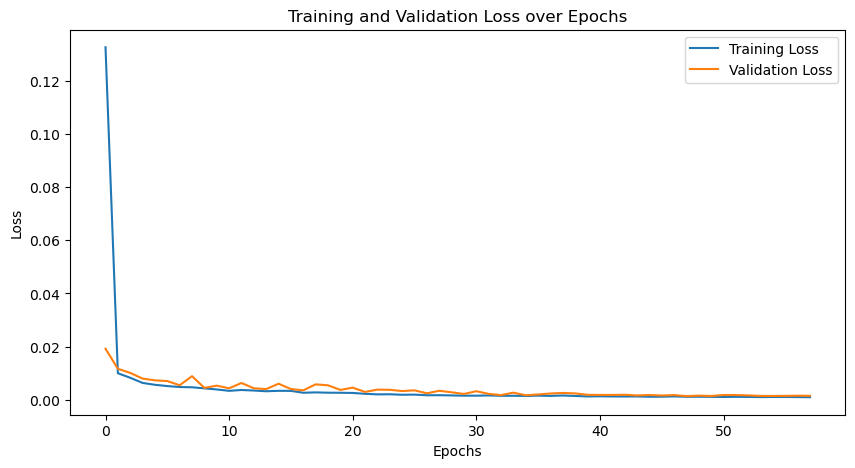

In [42]:
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm
import time
import matplotlib.pyplot as plt

# Ensure the model is moved to the GPU
model = model.to(device)

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=100, patience=10):
    scaler = GradScaler()
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience_counter = 0
    
    for epoch in range(num_epochs):
        start_time = time.time()
        model.train()
        running_loss = 0.0
        
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch"):
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            optimizer.zero_grad()
            
            with autocast():
                outputs = model(inputs.unsqueeze(1))  # Add batch dimension for LSTM--helps with loss score and validation to get low
                loss = criterion(outputs, labels)
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            running_loss += loss.item() * inputs.size(0)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        val_loss = validate_model(model, val_loader, criterion)
        
        train_losses.append(epoch_loss)
        val_losses.append(val_loss)
        
        scheduler.step(val_loss)
        
        epoch_time = time.time() - start_time
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Time: {epoch_time:.2f}s")
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping")
                model.load_state_dict(torch.load('best_model.pth'))
                break
    
    return train_losses, val_losses

# Validation function
def validate_model(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            with autocast():
                outputs = model(inputs.unsqueeze(1))  # Add batch dimension for LSTM
                loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
    
    val_loss = running_loss / len(val_loader.dataset)
    return val_loss

# Plot loss function
def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss over Epochs')
    plt.show()

# Number of epochs for training
num_epochs = 100

# Train the model and get the losses
train_losses, val_losses = train_model(model, train_buy_loader, val_buy_loader, criterion, optimizer, scheduler, num_epochs)

# Plot the losses
plot_losses(train_losses, val_losses)

Test Loss: 0.0020
Accuracy: 0.9993
Precision: 0.9991
Recall: 0.9987
F1 Score: 0.9989


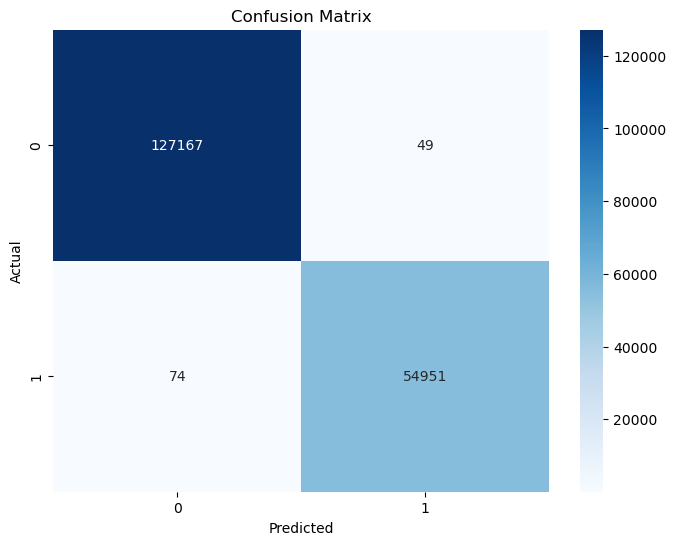

In [45]:
#F1 Score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

def evaluate_model(model, test_loader, criterion):
    model.eval()
    running_loss = 0.0
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            outputs = model(inputs.unsqueeze(1))  # Add batch dimension for LSTM
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    
    test_loss = running_loss / len(test_loader.dataset)
    print(f'Test Loss: {test_loss:.4f}')
    
    return all_labels, all_preds

# Evaluate on test_buy_loader or test_sell_loader depending on your focus
all_labels, all_preds = evaluate_model(model, test_buy_loader, criterion)

# Calculate metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# Plot confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [43]:
#Save the model:
import torch

# Save the entire model
torch.save(model, 'model.pth')

In [46]:
# Save the model
torch.save(model.state_dict(), 'model.pth')
print("Model saved successfully!")

Model saved successfully!


Target capital of 200000 reached at 2022-06-02 21:56:00, stopping trading.
Entered position at 2022-06-01 00:54:00, index 54, price: 31666.83, positions: 0.31578784488374745, capital: 100
Exited position at 2022-06-01 01:05:00, index 65, price: 31722.76, profit_percentage: 0.17662014164346937, capital: 117.66201416434694
Entered position at 2022-06-01 03:12:00, index 192, price: 31716.45, positions: 0.37098103401971827, capital: 117.66201416434694
Exited position at 2022-06-01 03:16:00, index 196, price: 31822.4, profit_percentage: 0.33405377966323696, capital: 156.96745471873638
Entered position at 2022-06-01 03:24:00, index 204, price: 31717.88, positions: 0.494886337670539, capital: 156.96745471873638
Exited position at 2022-06-01 03:27:00, index 207, price: 31802.16, profit_percentage: 0.2657176330826614, capital: 198.67647525760884
Entered position at 2022-06-01 03:31:00, index 211, price: 31830.02, positions: 0.6241795489214548, capital: 198.67647525760884
Exited position at 2022

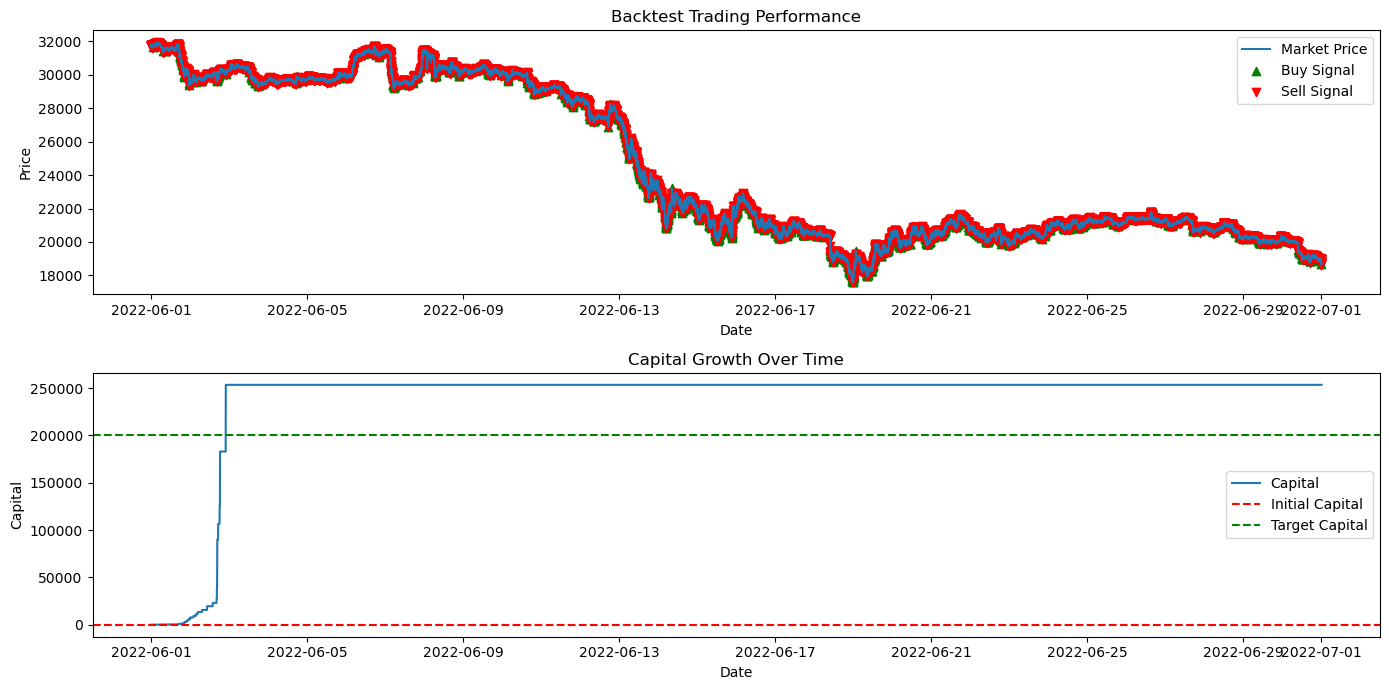

Precision: 1.0000
Recall: 0.6667
F1 Score: 0.8001
Accuracy: 0.9638


In [6]:
#Backtesting--Getting our Trained model
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Define the LSTM model
class BitcoinPriceLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.5):
        super(BitcoinPriceLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, hidden_size)
        self.fc5 = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out[:, -1, :])
        out = torch.relu(self.fc1(out))
        out = torch.relu(self.fc2(out))  # Added another activation
        out = torch.relu(self.fc3(out))  # Added another activation
        out = torch.relu(self.fc4(out))  # Added another activation
        out = self.fc5(out)
        return out

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model parameters
input_size = 11  # Adjust based on the number of features excluding 'Buy_Signal' and 'Sell_Signal'
hidden_size = 1024
num_layers = 6
output_size = 2

# Load the trained model
model_path = "C:/Users/gunne/Documents/PriceNeuralNetwork/model.pth"
model = BitcoinPriceLSTM(input_size, hidden_size, num_layers, output_size, dropout=0.5).to(device)
model.load_state_dict(torch.load(model_path))
model.eval()

# Load the backtest data
backtest_data_path = 'C:/Users/gunne/OneDrive/Desktop/bitcoin/trained/1walk_cleaned.csv'
backtest_data = pd.read_csv(backtest_data_path, parse_dates=['DateTime'], index_col='DateTime')

# Feature engineering
backtest_data['Change_Open_Close'] = ((backtest_data['CLOSE'] - backtest_data['OPEN']) / backtest_data['OPEN']) * 100
backtest_data['Change_High_Low'] = ((backtest_data['HIGH'] - backtest_data['LOW']) / backtest_data['HIGH']) * 100
backtest_data['Up_Or_Down'] = (backtest_data['Change_Open_Close'].diff() > 0).astype(int)
backtest_data['Profit_Between_Time_Series'] = backtest_data['Change_Open_Close'].diff().fillna(0)
backtest_data['Buy_Signal'] = (backtest_data['Profit_Between_Time_Series'] > 0.165).astype(int)
backtest_data['Sell_Signal'] = backtest_data['Buy_Signal'].shift(-1).fillna(0).astype(int)

# Prepare features for model prediction
features = backtest_data.drop(columns=['Buy_Signal', 'Sell_Signal']).values
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Predicting buy signals
with torch.no_grad():
    inputs = torch.tensor(scaled_features, dtype=torch.float32).to(device)
    outputs = model(inputs.unsqueeze(1))
    predicted_signals = torch.argmax(outputs, dim=1).cpu().numpy()

backtest_data['Predicted_Buy_Signal'] = predicted_signals

# Backtesting with leverage and profit cap
initial_capital = 100
capital = initial_capital
leverage = 100  # 1:100 leverage
capital_history = []

# Profit cap parameter
profit_cap_percentage = 0.165  # Cap the profit at this percentage
target_capital = 200000  # Target capital to stop trading

# Trade log
trade_log = []

# Initialize variables
entry_price = None
positions = 0

for i in range(len(backtest_data)):
    date_time = backtest_data.index[i]
    current_price = backtest_data['CLOSE'].iloc[i]

    if capital >= target_capital:
        print(f"Target capital of {target_capital} reached at {date_time}, stopping trading.")
        break

    if backtest_data['Predicted_Buy_Signal'].iloc[i] == 1 and positions == 0:
        # Enter position
        positions = leverage * (capital / current_price)
        entry_price = current_price
        trade_log.append(f"Entered position at {date_time}, index {i}, price: {entry_price}, positions: {positions}, capital: {capital}")
    
    if positions != 0:
        profit_percentage = (current_price - entry_price) / entry_price * 100
        
        if profit_percentage >= profit_cap_percentage or profit_percentage <= -1:
            
            # Compound the capital if profit was made
            if profit_percentage >= profit_cap_percentage:
                capital *= (1 + (profit_percentage / 100) * leverage)
                
            trade_log.append(f"Exited position at {date_time}, index {i}, price: {current_price}, profit_percentage: {profit_percentage}, capital: {capital}")
            
            # Reset positions
            positions = 0
            entry_price = None
    
    # Update capital history
    capital_history.append(capital)

# Fill the remaining capital history with the final capital value
if len(capital_history) < len(backtest_data):
    capital_history.extend([capital] * (len(backtest_data) - len(capital_history)))

# Output trade log
for log in trade_log:
    print(log)

# Plotting the results
backtest_data['Capital'] = capital_history

plt.figure(figsize=(14, 7))

plt.subplot(2, 1, 1)
plt.plot(backtest_data.index, backtest_data['CLOSE'], label='Market Price')
plt.scatter(backtest_data.index[backtest_data['Predicted_Buy_Signal'] == 1], backtest_data['CLOSE'][backtest_data['Predicted_Buy_Signal'] == 1], marker='^', color='green', alpha=1, label='Buy Signal')
plt.scatter(backtest_data.index[backtest_data['Predicted_Buy_Signal'] == 0], backtest_data['CLOSE'][backtest_data['Predicted_Buy_Signal'] == 0], marker='v', color='red', alpha=1, label='Sell Signal')
plt.title('Backtest Trading Performance')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(backtest_data.index, backtest_data['Capital'], label='Capital')
plt.axhline(y=initial_capital, color='r', linestyle='--', label='Initial Capital')
plt.axhline(y=target_capital, color='g', linestyle='--', label='Target Capital')
plt.title('Capital Growth Over Time')
plt.xlabel('Date')
plt.ylabel('Capital')
plt.legend()



plt.tight_layout()
plt.show()


# Calculate performance metrics
actual_signals = backtest_data['Buy_Signal'].values
precision = precision_score(actual_signals, predicted_signals)
recall = recall_score(actual_signals, predicted_signals)
f1 = f1_score(actual_signals, predicted_signals)
accuracy = accuracy_score(actual_signals, predicted_signals)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")

Entered position at 2022-06-01 12:00:00, index 24, price: 1.25884, positions: 79438.2129579613, capital: 1000
Exited position at 2022-06-07 08:30:00, index 209, price: 1.2448, profit_percentage: -1.1153125099297807, capital: 1000
Entered position at 2022-06-07 09:30:00, index 211, price: 1.24672, positions: 80210.47227926078, capital: 1000
Exited position at 2022-06-07 11:00:00, index 214, price: 1.25068, profit_percentage: 0.31763347022586974, capital: 1317.6334702258696
Entered position at 2022-06-07 16:00:00, index 224, price: 1.25015, positions: 105398.02985448703, capital: 1317.6334702258696
Exited position at 2022-06-07 16:30:00, index 225, price: 1.2524, profit_percentage: 0.17997840259167805, capital: 1554.7790373984508
Entered position at 2022-06-07 17:30:00, index 227, price: 1.258, positions: 123591.33842594997, capital: 1554.7790373984508
Exited position at 2022-06-10 13:30:00, index 363, price: 1.24445, profit_percentage: -1.077106518282985, capital: 1554.7790373984508
Ent

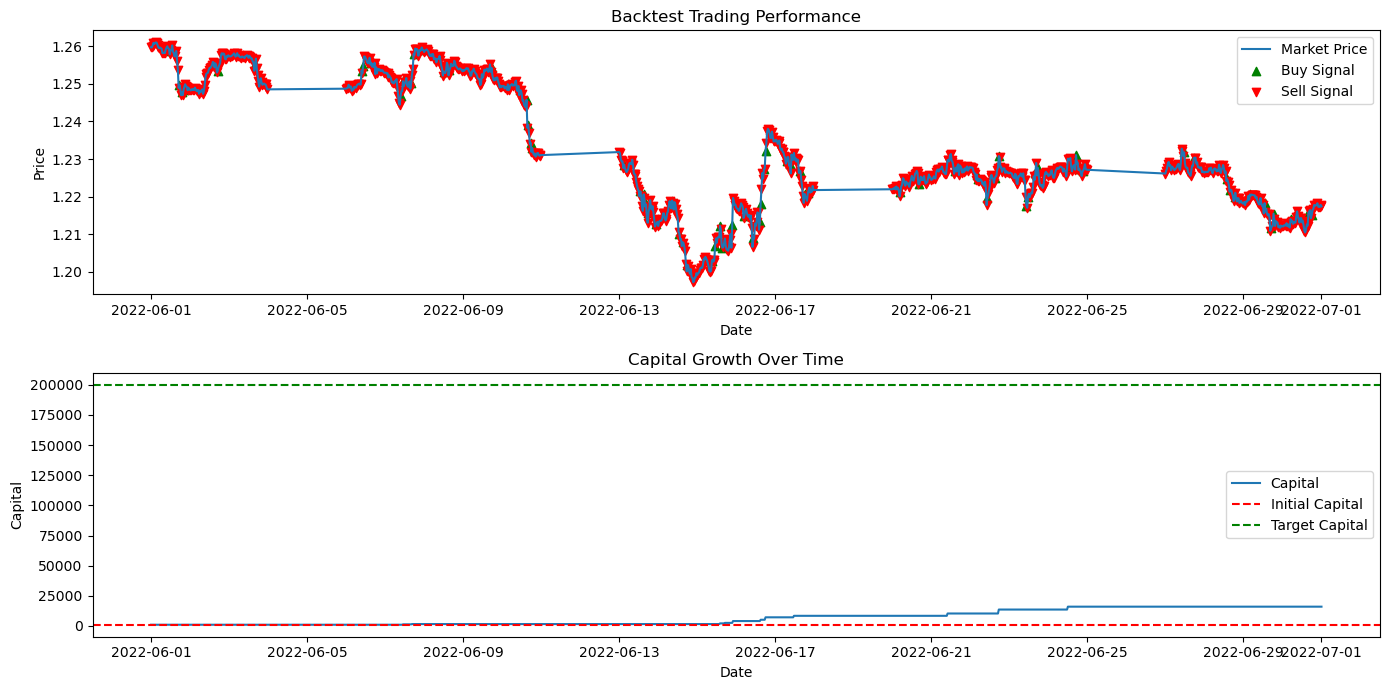

NameError: name 'precision_score' is not defined

In [32]:
#Backtesting-with forex
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Define the LSTM model
class BitcoinPriceLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.5):
        super(BitcoinPriceLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, hidden_size)
        self.fc5 = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out[:, -1, :])
        out = torch.relu(self.fc1(out))
        out = torch.relu(self.fc2(out))  # Added another activation
        out = torch.relu(self.fc3(out))  # Added another activation
        out = torch.relu(self.fc4(out))  # Added another activation
        out = self.fc5(out)
        return out

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model parameters
input_size = 11  # Adjust based on the number of features excluding 'Buy_Signal' and 'Sell_Signal'
hidden_size = 1024
num_layers = 6
output_size = 2

# Load the trained model
model_path = "C:/Users/gunne/Documents/PriceNeuralNetwork/model.pth"
model = BitcoinPriceLSTM(input_size, hidden_size, num_layers, output_size, dropout=0.5).to(device)
model.load_state_dict(torch.load(model_path))
model.eval()

# Load the backtest data
backtest_data_path = 'C:/Users/gunne/OneDrive/Desktop/bitcoin/trained/1monthforex_cleaned.csv'
backtest_data = pd.read_csv(backtest_data_path, parse_dates=['DateTime'], index_col='DateTime')

# Feature engineering
backtest_data['Change_Open_Close'] = ((backtest_data['CLOSE'] - backtest_data['OPEN']) / backtest_data['OPEN']) * 100
backtest_data['Change_High_Low'] = ((backtest_data['HIGH'] - backtest_data['LOW']) / backtest_data['HIGH']) * 100
backtest_data['Up_Or_Down'] = (backtest_data['Change_Open_Close'].diff() > 0).astype(int)
backtest_data['Profit_Between_Time_Series'] = backtest_data['Change_Open_Close'].diff().fillna(0)
backtest_data['Buy_Signal'] = (backtest_data['Profit_Between_Time_Series'] > 0.165).astype(int)
backtest_data['Sell_Signal'] = backtest_data['Buy_Signal'].shift(-1).fillna(0).astype(int)

# Prepare features for model prediction
features = backtest_data.drop(columns=['Buy_Signal', 'Sell_Signal']).values
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Predicting buy signals
with torch.no_grad():
    inputs = torch.tensor(scaled_features, dtype=torch.float32).to(device)
    outputs = model(inputs.unsqueeze(1))
    predicted_signals = torch.argmax(outputs, dim=1).cpu().numpy()

backtest_data['Predicted_Buy_Signal'] = predicted_signals

# Backtesting with leverage and profit cap
initial_capital = 1000
capital = initial_capital
leverage = 100  # 1:100 leverage
capital_history = []

# Profit cap parameter
profit_cap_percentage = 0.165  # Cap the profit at this percentage
target_capital = 200000  # Target capital to stop trading

# Trade log
trade_log = []

# Initialize variables
entry_price = None
positions = 0

for i in range(len(backtest_data)):
    date_time = backtest_data.index[i]
    current_price = backtest_data['CLOSE'].iloc[i]

    if capital >= target_capital:
        print(f"Target capital of {target_capital} reached at {date_time}, stopping trading.")
        break

    if backtest_data['Predicted_Buy_Signal'].iloc[i] == 1 and positions == 0:
        # Enter position
        positions = leverage * (capital / current_price)
        entry_price = current_price
        trade_log.append(f"Entered position at {date_time}, index {i}, price: {entry_price}, positions: {positions}, capital: {capital}")
    
    if positions != 0:
        profit_percentage = (current_price - entry_price) / entry_price * 100
        
        if profit_percentage >= profit_cap_percentage or profit_percentage <= -1:
            
            # Compound the capital if profit was made
            if profit_percentage >= profit_cap_percentage:
                capital *= (1 + (profit_percentage / 100) * leverage)
                
            trade_log.append(f"Exited position at {date_time}, index {i}, price: {current_price}, profit_percentage: {profit_percentage}, capital: {capital}")
            
            # Reset positions
            positions = 0
            entry_price = None
    
    # Update capital history
    capital_history.append(capital)

# Fill the remaining capital history with the final capital value
if len(capital_history) < len(backtest_data):
    capital_history.extend([capital] * (len(backtest_data) - len(capital_history)))

# Output trade log
for log in trade_log:
    print(log)

# Plotting the results
backtest_data['Capital'] = capital_history

plt.figure(figsize=(14, 7))

plt.subplot(2, 1, 1)
plt.plot(backtest_data.index, backtest_data['CLOSE'], label='Market Price')
plt.scatter(backtest_data.index[backtest_data['Predicted_Buy_Signal'] == 1], backtest_data['CLOSE'][backtest_data['Predicted_Buy_Signal'] == 1], marker='^', color='green', alpha=1, label='Buy Signal')
plt.scatter(backtest_data.index[backtest_data['Predicted_Buy_Signal'] == 0], backtest_data['CLOSE'][backtest_data['Predicted_Buy_Signal'] == 0], marker='v', color='red', alpha=1, label='Sell Signal')
plt.title('Backtest Trading Performance')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(backtest_data.index, backtest_data['Capital'], label='Capital')
plt.axhline(y=initial_capital, color='r', linestyle='--', label='Initial Capital')
plt.axhline(y=target_capital, color='g', linestyle='--', label='Target Capital')
plt.title('Capital Growth Over Time')
plt.xlabel('Date')
plt.ylabel('Capital')
plt.legend()



plt.tight_layout()
plt.show()


# Calculate performance metrics
actual_signals = backtest_data['Buy_Signal'].values
precision = precision_score(actual_signals, predicted_signals)
recall = recall_score(actual_signals, predicted_signals)
f1 = f1_score(actual_signals, predicted_signals)
accuracy = accuracy_score(actual_signals, predicted_signals)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")

In [23]:
#Backtesting--Connecting with MetaTrader5 data with ICMarketsSC-Demo Bitcoin account 
# Install Required Packages
!pip install --upgrade pip
!pip install --force-reinstall --no-binary :all: tbb
!pip install MetaTrader5 pandas numpy torch matplotlib scikit-learn

# Imports and Model Definition
import MetaTrader5 as mt5
import pandas as pd
import datetime
import torch
import torch.nn as nn
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Define the LSTM model
class BitcoinPriceLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.5):
        super(BitcoinPriceLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, hidden_size)
        self.fc5 = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out[:, -1, :])
        out = torch.relu(self.fc1(out))
        out = torch.relu(self.fc2(out))
        out = torch.relu(self.fc3(out))
        out = torch.relu(self.fc4(out))
        out = self.fc5(out)
        return out

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the trained model
model_path = "C:/Users/gunne/Documents/PriceNeuralNetwork/model.pth"
model = BitcoinPriceLSTM(input_size=11, hidden_size=1024, num_layers=6, output_size=2, dropout=0.5).to(device)
model.load_state_dict(torch.load(model_path))
model.eval()

# Connect to MetaTrader 5
if not mt5.initialize():
    print("initialize() failed")
    mt5.shutdown()
else:
    print("MetaTrader 5 initialized successfully")

# Login to the demo account
account = 51806647  # Ensure the account number is an integer
password = "lKDtOjEK6$rp@f"
server = "ICMarketsSC-Demo"

# Debug print for login details
print(f"Attempting to login with Account: {account}, Password: {password}, Server: {server}")

authorized = mt5.login(login=account, password=password, server=server)
if not authorized:
    print(f"Failed to connect to account #{account}, error code: {mt5.last_error()}")
else:
    print(f"Connected to account #{account}")

  Obtaining dependency information for pip from https://files.pythonhosted.org/packages/8a/6a/19e9fe04fca059ccf770861c7d5721ab4c2aebc539889e97c7977528a53b/pip-24.0-py3-none-any.whl.metadata
  Using cached pip-24.0-py3-none-any.whl.metadata (3.6 kB)
Using cached pip-24.0-py3-none-any.whl (2.1 MB)


ERROR: To modify pip, please run the following command:
C:\Users\gunne\anaconda3\python.exe -m pip install --upgrade pip
ERROR: Could not find a version that satisfies the requirement tbb (from versions: none)
ERROR: No matching distribution found for tbb


  Obtaining dependency information for tbb==2021.* from https://files.pythonhosted.org/packages/7b/2d/1e1c70fae8ace27e6200fb71c2372a9aeac2baba474b1609d7d466e969b4/tbb-2021.12.0-py3-none-win_amd64.whl.metadata
  Using cached tbb-2021.12.0-py3-none-win_amd64.whl.metadata (1.1 kB)
Using cached tbb-2021.12.0-py3-none-win_amd64.whl (286 kB)
  Attempting uninstall: tbb
    Found existing installation: TBB 0.2


ERROR: Cannot uninstall 'TBB'. It is a distutils installed project and thus we cannot accurately determine which files belong to it which would lead to only a partial uninstall.


MetaTrader 5 initialized successfully
Attempting to login with Account: 51806647, Password: lKDtOjEK6$rp@f, Server: ICMarketsSC-Demo
Connected to account #51806647


Fetched 42595 rates
Entered position at index 108, time 2022-06-01 00:54:00, price: 31659.89, positions: 0.03158570670965692, capital: 100
Exited position at index 119, time 2022-06-01 01:05:00, price: 31726.91, profit_percentage: 0.21168740636812203, profit: 211.68740636812208, capital: 311.6874063681221
Entered position at index 246, time 2022-06-01 03:12:00, price: 31710.44, positions: 0.03153535554851967, capital: 523.3748127362442
Exited position at index 250, time 2022-06-01 03:16:00, price: 31820.36, profit_percentage: 0.34663662818933416, profit: 346.63662818933415, capital: 870.0114409255783
Entered position at index 258, time 2022-06-01 03:24:00, price: 31722.34, positions: 0.03152352569198868, capital: 1216.6480691149125
Exited position at index 261, time 2022-06-01 03:27:00, price: 31801.84, profit_percentage: 0.25061202925130993, profit: 250.61202925131002, capital: 1467.2600983662226
Entered position at index 265, time 2022-06-01 03:31:00, price: 31830.34, positions: 0.03

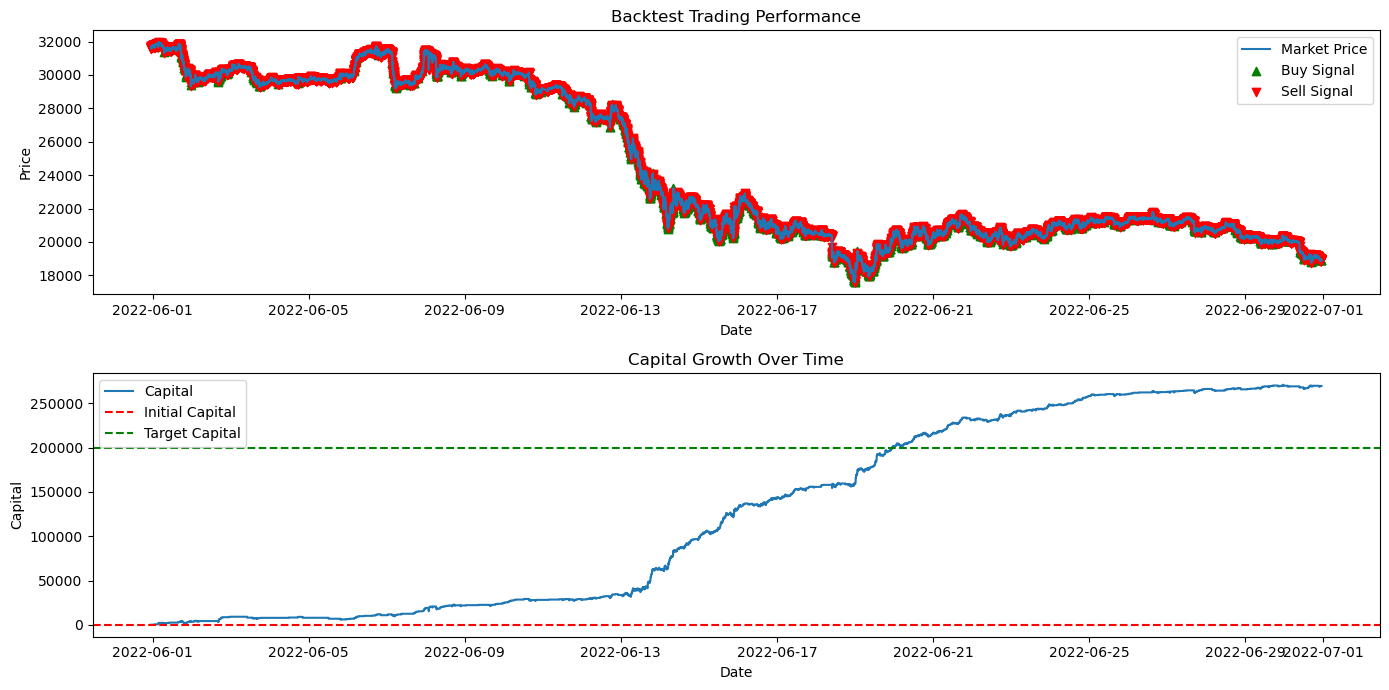

In [30]:
#Backtesting--Part 2
# Fetch historical data from MetaTrader 5
symbol = "BTCUSD"
timeframe = mt5.TIMEFRAME_M1
utc_from = datetime.datetime(2022, 6, 1)
utc_to = datetime.datetime(2022, 7, 1)
rates = mt5.copy_rates_range(symbol, timeframe, utc_from, utc_to)
if rates is None:
    print("Failed to fetch rates, error code:", mt5.last_error())
else:
    print(f"Fetched {len(rates)} rates")

# Create DataFrame from the rates
rates_frame = pd.DataFrame(rates)
rates_frame['time'] = pd.to_datetime(rates_frame['time'], unit='s')
rates_frame.set_index('time', inplace=True)

# Feature engineering
rates_frame['Change_Open_Close'] = ((rates_frame['close'] - rates_frame['open']) / rates_frame['open']) * 100
rates_frame['Change_High_Low'] = ((rates_frame['high'] - rates_frame['low']) / rates_frame['high']) * 100
rates_frame['Up_Or_Down'] = (rates_frame['Change_Open_Close'].diff() > 0).astype(int)
rates_frame['Profit_Between_Time_Series'] = rates_frame['Change_Open_Close'].diff().fillna(0)
rates_frame['Buy_Signal'] = (rates_frame['Profit_Between_Time_Series'] > 0.165).astype(int)
rates_frame['Sell_Signal'] = rates_frame['Buy_Signal'].shift(-1).fillna(0).astype(int)

# Prepare features for model prediction
features = rates_frame.drop(columns=['Buy_Signal', 'Sell_Signal']).values
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Predicting buy signals
with torch.no_grad():
    inputs = torch.tensor(scaled_features, dtype=torch.float32).to(device)
    outputs = model(inputs.unsqueeze(1))
    predicted_signals = torch.argmax(outputs, dim=1).cpu().numpy()

rates_frame['Predicted_Buy_Signal'] = predicted_signals

# Backtesting with leverage and profit cap
initial_capital = 100
risk_per_trade = 10  # Risking $10 per trade
capital = initial_capital
leverage = 100  # 1:100 leverage
capital_history = []

# Profit cap parameter
profit_cap_percentage = 0.165  # Cap the profit at this percentage

# Trade log
trade_log = []

# Initialize variables
entry_price = None
positions = 0

for i in range(len(rates_frame)):
    date_time = rates_frame.index[i]
    current_price = rates_frame['close'].iloc[i]

    if rates_frame['Predicted_Buy_Signal'].iloc[i] == 1 and positions == 0:
        # Enter position
        positions = leverage * (risk_per_trade / current_price)
        entry_price = current_price
        trade_log.append(f"Entered position at index {i}, time {date_time}, price: {entry_price}, positions: {positions}, capital: {capital}")

    if positions != 0:
        profit_percentage = (current_price - entry_price) / entry_price * 100

        if profit_percentage >= profit_cap_percentage or profit_percentage <= -1:
            # Exit position due to reaching profit cap or stop loss
            profit = positions * (current_price - entry_price) * leverage
            capital += profit

            trade_log.append(f"Exited position at index {i}, time {date_time}, price: {current_price}, profit_percentage: {profit_percentage}, profit: {profit}, capital: {capital}")

            # Compound the capital if profit was made
            if profit_percentage >= profit_cap_percentage:
                capital += profit  # Add profit directly to capital

            # Reset positions
            positions = 0
            entry_price = None

    # Update capital history
    capital_history.append(capital)

# Output trade log
for log in trade_log:
    print(log)

# Plotting the results
rates_frame['Capital'] = capital_history

plt.figure(figsize=(14, 7))

plt.subplot(2, 1, 1)
plt.plot(rates_frame.index, rates_frame['close'], label='Market Price')
plt.scatter(rates_frame.index[rates_frame['Predicted_Buy_Signal'] == 1], rates_frame['close'][rates_frame['Predicted_Buy_Signal'] == 1], marker='^', color='green', alpha=1, label='Buy Signal')
plt.scatter(rates_frame.index[rates_frame['Predicted_Buy_Signal'] == 0], rates_frame['close'][rates_frame['Predicted_Buy_Signal'] == 0], marker='v', color='red', alpha=1, label='Sell Signal')
plt.title('Backtest Trading Performance')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(rates_frame.index, rates_frame['Capital'], label='Capital')
plt.axhline(y=initial_capital, color='r', linestyle='--', label='Initial Capital')
plt.axhline(y=200000, color='g', linestyle='--', label='Target Capital')
plt.title('Capital Growth Over Time')
plt.xlabel('Date')
plt.ylabel('Capital')
plt.legend()

plt.tight_layout()
plt.show()

In [33]:
#Backtesting--Continuous testing, for each minute, 60 minutes:
import MetaTrader5 as mt5
import pandas as pd
import datetime
import torch
import torch.nn as nn
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import time

# Define the LSTM model
class BitcoinPriceLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.5):
        super(BitcoinPriceLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, hidden_size)
        self.fc5 = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out[:, -1, :])
        out = torch.relu(self.fc1(out))
        out = torch.relu(self.fc2(out))
        out = torch.relu(self.fc3(out))
        out = torch.relu(self.fc4(out))
        out = self.fc5(out)
        return out

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the trained model
model_path = "C:/Users/gunne/Documents/PriceNeuralNetwork/model.pth"
model = BitcoinPriceLSTM(input_size=11, hidden_size=1024, num_layers=6, output_size=2, dropout=0.5).to(device)
model.load_state_dict(torch.load(model_path))
model.eval()

# Connect to MetaTrader 5
if not mt5.initialize():
    print("initialize() failed")
    mt5.shutdown()
else:
    print("MetaTrader 5 initialized successfully")

MetaTrader 5 initialized successfully


In [20]:
#Backtesting
# Install Required Packages
!pip install MetaTrader5 pandas numpy torch matplotlib scikit-learn

# Imports and Model Definition
import MetaTrader5 as mt5
import pandas as pd
import datetime
import torch
import torch.nn as nn
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import time

# Define the LSTM model
class BitcoinPriceLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.5):
        super(BitcoinPriceLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, hidden_size)
        self.fc5 = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out[:, -1, :])
        out = torch.relu(self.fc1(out))
        out = torch.relu(self.fc2(out))
        out = torch.relu(self.fc3(out))
        out = torch.relu(self.fc4(out))
        out = self.fc5(out)
        return out

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on device: {device}")

# Load the trained model
model_path = "C:/Users/gunne/Documents/PriceNeuralNetwork/model.pth"
model = BitcoinPriceLSTM(input_size=11, hidden_size=1024, num_layers=6, output_size=2, dropout=0.5).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

# Connect to MetaTrader 5
if not mt5.initialize():
    print("initialize() failed")
    mt5.shutdown()
else:
    print("MetaTrader 5 initialized successfully")

# Login to the demo account
account = 51806647  # Ensure the account number is an integer
password = "lKDtOjEK6$rp@f"
server = "ICMarketsSC-Demo"

# Debug print for login details
print(f"Attempting to login with Account: {account}, Password: {password}, Server: {server}")

authorized = mt5.login(login=account, password=password, server=server)
if not authorized:
    print(f"Failed to connect to account #{account}, error code: {mt5.last_error()}")
else:
    print(f"Connected to account #{account}")


ERROR: Cannot uninstall 'TBB'. It is a distutils installed project and thus we cannot accurately determine which files belong to it which would lead to only a partial uninstall.


  Obtaining dependency information for tbb==2021.* from https://files.pythonhosted.org/packages/7b/2d/1e1c70fae8ace27e6200fb71c2372a9aeac2baba474b1609d7d466e969b4/tbb-2021.12.0-py3-none-win_amd64.whl.metadata
  Using cached tbb-2021.12.0-py3-none-win_amd64.whl.metadata (1.1 kB)
Using cached tbb-2021.12.0-py3-none-win_amd64.whl (286 kB)
  Attempting uninstall: tbb
    Found existing installation: TBB 0.2
Running on device: cuda
MetaTrader 5 initialized successfully
Attempting to login with Account: 51806647, Password: lKDtOjEK6$rp@f, Server: ICMarketsSC-Demo
Connected to account #51806647


In [21]:
import os
import shutil

# Set up initial capital
initial_capital = 100  # Use $100 from the initial balance
capital = initial_capital
profit_cap_percentage = 0.165
stop_loss_percentage = 0.1  # Stop loss at 0.1%
positions = 0
entry_price = None

# Trade log
trade_log = []

# Create a new folder for the current test
current_test_index = 0
base_log_dir = "C:/Users/gunne/Documents/PriceNeuralNetwork/trading_logs"
os.makedirs(base_log_dir, exist_ok=True)

# Find the next available folder index
while os.path.exists(os.path.join(base_log_dir, f"test_{current_test_index}")):
    current_test_index += 1

current_log_dir = os.path.join(base_log_dir, f"test_{current_test_index}")
os.makedirs(current_log_dir)

log_file_path = os.path.join(current_log_dir, "trade_log.csv")

# DataFrame for logs
trade_log_df = pd.DataFrame(columns=['time', 'action', 'price', 'positions', 'capital', 'profit_percentage', 'profit'])

# Function to place a market order
def place_order(symbol, order_type, volume, price, stop_loss, take_profit):
    request = {
        "action": mt5.TRADE_ACTION_DEAL,
        "symbol": symbol,
        "volume": volume,
        "type": order_type,
        "price": price,
        "sl": stop_loss,
        "tp": take_profit,
        "deviation": 20,
        "magic": 234000,
        "comment": "python script open",
        "type_time": mt5.ORDER_TIME_GTC,
        "type_filling": mt5.ORDER_FILLING_IOC,
    }

    result = mt5.order_send(request)
    return result

# Run the trading loop
while True:
    # Fetch live data
    rates = mt5.copy_rates_from_pos("BTCUSD", mt5.TIMEFRAME_M1, 0, 100)
    rates_frame = pd.DataFrame(rates)
    rates_frame['time'] = pd.to_datetime(rates_frame['time'], unit='s')
    rates_frame.set_index('time', inplace=True)

    # Feature engineering
    rates_frame['Change_Open_Close'] = ((rates_frame['close'] - rates_frame['open']) / rates_frame['open']) * 100
    rates_frame['Change_High_Low'] = ((rates_frame['high'] - rates_frame['low']) / rates_frame['high']) * 100
    rates_frame['Up_Or_Down'] = (rates_frame['Change_Open_Close'].diff() > 0).astype(int)
    rates_frame['Profit_Between_Time_Series'] = rates_frame['Change_Open_Close'].diff().fillna(0)
    rates_frame['Buy_Signal'] = (rates_frame['Profit_Between_Time_Series'] > 0.165).astype(int)
    rates_frame['Sell_Signal'] = rates_frame['Buy_Signal'].shift(-1).fillna(0).astype(int)

    # Prepare features for model prediction
    features = rates_frame.drop(columns=['Buy_Signal', 'Sell_Signal']).values
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)

    # Predicting buy signals
    with torch.no_grad():
        inputs = torch.tensor(scaled_features, dtype=torch.float32).to(device)
        outputs = model(inputs.unsqueeze(1))
        predicted_signals = torch.argmax(outputs, dim=1).cpu().numpy()

    rates_frame['Predicted_Buy_Signal'] = predicted_signals

    # Execute trades based on predictions
    current_price = rates_frame['close'].iloc[-1]
    date_time = datetime.datetime.now()
    risk_per_trade = initial_capital  # Risk 100% of the initial $100

    if rates_frame['Predicted_Buy_Signal'].iloc[-1] == 1 and positions == 0:
        # Enter position
        positions = risk_per_trade / current_price
        entry_price = current_price
        stop_loss_price = entry_price * (1 - stop_loss_percentage / 100)
        take_profit_price = entry_price * (1 + profit_cap_percentage / 100)
        log_entry = {
            'time': date_time,
            'action': 'enter',
            'price': entry_price,
            'positions': positions,
            'capital': capital,
            'profit_percentage': None,
            'profit': None
        }
        trade_log_df = pd.concat([trade_log_df, pd.DataFrame([log_entry])], ignore_index=True)
        trade_log_df.to_csv(log_file_path, index=False, mode='a', header=not os.path.exists(log_file_path))

        # Place a buy order
        order_type = mt5.ORDER_TYPE_BUY
        volume = positions
        result = place_order("BTCUSD", order_type, volume, entry_price, stop_loss_price, take_profit_price)
        if result.retcode != mt5.TRADE_RETCODE_DONE:
            print(f"Failed to place buy order: {result.retcode}")

    if positions != 0:
        profit_percentage = (current_price - entry_price) / entry_price * 100

        if profit_percentage >= profit_cap_percentage or current_price <= stop_loss_price:
            # Exit position due to reaching profit cap or stop loss
            profit = positions * (current_price - entry_price)
            capital += profit

            if current_price <= stop_loss_price:
                # Reduce capital by the risked amount
                capital -= initial_capital  # Deducting the initial $100 risked

            log_exit = {
                'time': date_time,
                'action': 'exit',
                'price': current_price,
                'positions': positions,
                'capital': capital,
                'profit_percentage': profit_percentage,
                'profit': profit
            }
            trade_log_df = pd.concat([trade_log_df, pd.DataFrame([log_exit])], ignore_index=True)
            trade_log_df.to_csv(log_file_path, index=False, mode='a', header=not os.path.exists(log_file_path))

            # Place a sell order to exit the position
            order_type = mt5.ORDER_TYPE_SELL
            volume = positions
            result = place_order("BTCUSD", order_type, volume, current_price, stop_loss_price, take_profit_price)
            if result.retcode != mt5.TRADE_RETCODE_DONE:
                print(f"Failed to place sell order: {
        result = place_order("BTCUSD", order_type, volume, entry_price, stop_loss_price, take_profit_price)
        if result.retcode != mt5.TRADE_RETCODE_DONE:
            print(f"Failed to place buy order: {result.retcode}")

    if positions != 0:
        profit_percentage = (current_price - entry_price) / entry_price * 100

        if profit_percentage >= profit_cap_percentage or current_price <= stop_loss_price:
            # Exit position due to reaching profit cap or stop loss
            profit = positions * (current_price - entry_price)
            capital += profit

            if current_price <= stop_loss_price:
                # Reduce capital by the risked amount
                capital -= initial_capital  # Deducting the initial $100 risked

            log_exit = {
                'time': date_time,
                'action': 'exit',
                'price': current_price,
                'positions': positions,
                'capital': capital,
                'profit_percentage': profit_percentage,
                'profit': profit
            }
            trade_log_df = pd.concat([trade_log_df, pd.DataFrame([log_exit])], ignore_index=True)
            trade_log_df.to_csv(log_file_path, index=False, mode='a', header=not os.path.exists(log_file_path))

            # Place a sell order to exit the position
            order_type = mt5.ORDER_TYPE_SELL
            volume = positions
            result = place_order("BTCUSD", order_type, volume, current_price, stop_loss_price, take_profit_price)
            if result.retcode != mt5.TRADE_RETCODE_DONE:
                print(f"Failed to place sell order: {result.retcode}")

            # Reset positions
            positions = 0
            entry_price = None

    # Print details of each iteration
    iteration_log = {
        'time': date_time,
        'action': 'iteration',
        'price': current_price,
        'positions': positions,
        'capital': capital,
        'profit_percentage': None,
        'profit': None
    }
    trade_log_df = pd.concat([trade_log_df, pd.DataFrame([iteration_log])], ignore_index=True)
    trade_log_df.to_csv(log_file_path, index=False, mode='a', header=not os.path.exists(log_file_path))
    print(f"Iteration at time {date_time}, current price: {current_price}, positions: {positions}, capital: {capital}")

    # Wait before the next iteration (e.g., 1 minute)
    time.sleep(60)

SyntaxError: unterminated string literal (detected at line 140) (926758777.py, line 140)

In [2]:
#Now lets do this with the dummy money traded with our account:
import os
import shutil
import MetaTrader5 as mt5
import pandas as pd
import datetime
import torch
import torch.nn as nn
import numpy as np
import time
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Define the LSTM model
class BitcoinPriceLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.5):
        super(BitcoinPriceLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, hidden_size)
        self.fc5 = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out[:, -1, :])
        out = torch.relu(self.fc1(out))
        out = torch.relu(self.fc2(out))
        out = torch.relu(self.fc3(out))
        out = torch.relu(self.fc4(out))
        out = self.fc5(out)
        return out

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the trained model
model_path = "C:/Users/gunne/Documents/PriceNeuralNetwork/model.pth"
model = BitcoinPriceLSTM(input_size=11, hidden_size=1024, num_layers=6, output_size=2, dropout=0.5).to(device)
model.load_state_dict(torch.load(model_path))
model.eval()

# Connect to MetaTrader 5
if not mt5.initialize():
    print("initialize() failed")
    mt5.shutdown()
else:
    print("MetaTrader 5 initialized successfully")

# Login to the demo account
account = 51806647  # Ensure the account number is an integer
password = "lKDtOjEK6$rp@f"
server = "ICMarketsSC-Demo"

# Debug print for login details
print(f"Attempting to login with Account: {account}, Password: {password}, Server: {server}")

authorized = mt5.login(login=account, password=password, server=server)
if not authorized:
    print("Failed to connect to account #{account}, error code: {mt5.last_error()}")
else:
    print(f"Connected to account #{account}")

MetaTrader 5 initialized successfully
Attempting to login with Account: 51806647, Password: lKDtOjEK6$rp@f, Server: ICMarketsSC-Demo
Connected to account #51806647


In [4]:
#Now lets do this with the dummy money traded with our account, part 2:

# Trading parameters
initial_capital = 1000
capital = initial_capital
leverage = 1  # No leverage used
daily_profit_target = 400
stop_loss_percentage = 1.0  # Stop loss at 1%
positions = 0
entry_price = None

# Trade log
trade_log = []

# Create a new folder for the current test
current_test_index = 0
base_log_dir = "trading_logs"
os.makedirs(base_log_dir, exist_ok=True)

# Find the next available folder index
while os.path.exists(os.path.join(base_log_dir, f"test_{current_test_index}")):
    current_test_index += 1

current_log_dir = os.path.join(base_log_dir, f"test_{current_test_index}")
os.makedirs(current_log_dir)

log_file_path = os.path.join(current_log_dir, "trade_log.txt")
log_csv_path = os.path.join(current_log_dir, "trade_log.csv")
iteration_csv_path = os.path.join(current_log_dir, "iteration_log.csv")

# DataFrames for logs
trade_log_df = pd.DataFrame(columns=['time', 'action', 'price', 'positions', 'capital', 'profit_percentage', 'profit'])
iteration_log_df = pd.DataFrame(columns=['time', 'price', 'positions', 'capital'])

def validate_volume(raw_volume, symbol):
    # Adjust the volume to match the broker's requirements
    min_volume = mt5.symbol_info(symbol).volume_min
    max_volume = mt5.symbol_info(symbol).volume_max
    step_volume = mt5.symbol_info(symbol).volume_step

    if raw_volume < min_volume:
        return min_volume
    elif raw_volume > max_volume:
        return max_volume
    else:
        return round(raw_volume / step_volume) * step_volume

# Calculate the number of required trades
trades_needed = daily_profit_target / (initial_capital * 0.165 / 100)
print(f"Number of required trades to achieve the daily profit target: {trades_needed}")

# Run the trading loop
daily_profit = 0
while daily_profit < daily_profit_target:
    # Fetch live data
    rates = mt5.copy_rates_from_pos("BTCUSD", mt5.TIMEFRAME_M1, 0, 100)
    rates_frame = pd.DataFrame(rates)
    rates_frame['time'] = pd.to_datetime(rates_frame['time'], unit='s')
    rates_frame.set_index('time', inplace=True)

    # Feature engineering
    rates_frame['Change_Open_Close'] = ((rates_frame['close'] - rates_frame['open']) / rates_frame['open']) * 100
    rates_frame['Change_High_Low'] = ((rates_frame['high'] - rates_frame['low']) / rates_frame['high']) * 100
    rates_frame['Up_Or_Down'] = (rates_frame['Change_Open_Close'].diff() > 0).astype(int)
    rates_frame['Profit_Between_Time_Series'] = rates_frame['Change_Open_Close'].diff().fillna(0)
    rates_frame['Buy_Signal'] = (rates_frame['Profit_Between_Time_Series'] > 0.165).astype(int)
    rates_frame['Sell_Signal'] = rates_frame['Buy_Signal'].shift(-1).fillna(0).astype(int)

    # Prepare features for model prediction
    features = rates_frame.drop(columns=['Buy_Signal', 'Sell_Signal']).values
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)

    # Predicting buy signals
    with torch.no_grad():
        inputs = torch.tensor(scaled_features, dtype=torch.float32).to(device)
        outputs = model(inputs.unsqueeze(1))
        predicted_signals = torch.argmax(outputs, dim=1).cpu().numpy()

    rates_frame['Predicted_Buy_Signal'] = predicted_signals

    # Execute trades based on predictions
    current_price = rates_frame['close'].iloc[-1]
    date_time = datetime.datetime.now()
    risk_per_trade = capital * 0.01  # Risk 1% of current capital per trade

    # Calculate target profit per trade to achieve the daily target
    target_profit_per_trade = daily_profit_target / trades_needed

    if rates_frame['Predicted_Buy_Signal'].iloc[-1] == 1 and positions == 0:
        # Enter position
        raw_volume = target_profit_per_trade / (current_price * 0.165 / 100)
        validated_volume = validate_volume(raw_volume, "BTCUSD")

        positions = validated_volume
        entry_price = current_price
        stop_loss_price = entry_price - (entry_price * stop_loss_percentage / 100)
        log_entry = {
            'time': date_time,
            'action': 'enter',
            'price': entry_price,
            'positions': positions,
            'capital': capital,
            'profit_percentage': None,
            'profit': None
        }
        trade_log_df = pd.concat([trade_log_df, pd.DataFrame([log_entry])], ignore_index=True)
        with open(log_file_path, "a") as log_file:
            log_file.write(f"Entered position at time {date_time}, price: {entry_price}, positions: {positions}, capital: {capital}\n")

    if positions != 0:
        profit_percentage = (current_price - entry_price) / entry_price * 100

        if profit_percentage >= 0.165 or current_price <= stop_loss_price:
            # Exit position due to reaching profit cap or stop loss
            profit = positions * (current_price - entry_price) * leverage
            capital += profit
            daily_profit += profit

            if current_price <= stop_loss_price:
                # Reduce capital by the risked amount
                capital -= risk_per_trade
                daily_profit -= risk_per_trade

            log_exit = {
                'time': date_time,
                'action': 'exit',
                'price': current_price,
                'positions': positions,
                'capital': capital,
                'profit_percentage': profit_percentage,
                'profit': profit
            }
            trade_log_df = pd.concat([trade_log_df, pd.DataFrame([log_exit])], ignore_index=True)
            with open(log_file_path, "a") as log_file:
                log_file.write(f"Exited position at time {date_time}, price: {current_price}, profit_percentage: {profit_percentage}, profit: {profit}, capital: {capital}\n")

            # Reset positions
            positions = 0
            entry_price = None

    # Print details of each iteration
    iteration_log = {
        'time': date_time,
        'price': current_price,
        'positions': positions,
        'capital': capital
    }
    iteration_log_df = pd.concat([iteration_log_df, pd.DataFrame([iteration_log])], ignore_index=True)
    print(f"Iteration at time {date_time}, current price: {current_price}, positions: {positions}, capital: {capital}, daily profit: {daily_profit}")
    with open(log_file_path, "a") as log_file:
        log_file.write(f"Iteration at time {date_time}, current price: {current_price}, positions: {positions}, capital: {capital}, daily profit: {daily_profit}\n")

    # Save logs to CSV files
    trade_log_df.to_csv(log_csv_path, index=False)
    iteration_log_df.to_csv(iteration_csv_path, index=False)

    # Wait before the next iteration (e.g., 1 minute)
    time.sleep(60)

    # Reset daily profit at the end of the trading day (assumes a 24-hour trading day for simplicity)
    if date_time.hour == 0 and date_time.minute == 0:
        daily_profit = 0


Number of required trades to achieve the daily profit target: 242.42424242424244
Iteration at time 2024-05-27 16:25:31.099638, current price: 69780.84, positions: 0, capital: 1000, daily profit: 0
Iteration at time 2024-05-27 16:26:31.117283, current price: 69756.3, positions: 0, capital: 1000, daily profit: 0
Iteration at time 2024-05-27 16:27:31.129762, current price: 69746.72, positions: 0, capital: 1000, daily profit: 0
Iteration at time 2024-05-27 16:28:31.147746, current price: 69704.23, positions: 0, capital: 1000, daily profit: 0
Iteration at time 2024-05-27 16:29:31.164284, current price: 69742.08, positions: 0, capital: 1000, daily profit: 0
Iteration at time 2024-05-27 16:30:31.175709, current price: 69772.57, positions: 0, capital: 1000, daily profit: 0
Iteration at time 2024-05-27 16:31:31.189012, current price: 69808.74, positions: 0, capital: 1000, daily profit: 0
Iteration at time 2024-05-27 16:32:31.207105, current price: 69810.25, positions: 0, capital: 1000, daily pr

Iteration at time 2024-05-27 17:27:32.003012, current price: 70435.13, positions: 0.01, capital: 1001.6954, daily profit: 1.695399999999936
Iteration at time 2024-05-27 17:28:32.020624, current price: 70402.47, positions: 0.01, capital: 1001.6954, daily profit: 1.695399999999936
Iteration at time 2024-05-27 17:29:32.038788, current price: 70401.44, positions: 0.01, capital: 1001.6954, daily profit: 1.695399999999936
Iteration at time 2024-05-27 17:30:32.051753, current price: 70368.71, positions: 0.01, capital: 1001.6954, daily profit: 1.695399999999936
Iteration at time 2024-05-27 17:31:32.071129, current price: 70383.03, positions: 0.01, capital: 1001.6954, daily profit: 1.695399999999936
Iteration at time 2024-05-27 17:32:32.089141, current price: 70391.0, positions: 0.01, capital: 1001.6954, daily profit: 1.695399999999936
Iteration at time 2024-05-27 17:33:32.099973, current price: 70345.02, positions: 0.01, capital: 1001.6954, daily profit: 1.695399999999936
Iteration at time 202

Iteration at time 2024-05-27 18:26:32.974698, current price: 70065.04, positions: 0.01, capital: 1001.6954, daily profit: 1.695399999999936
Iteration at time 2024-05-27 18:27:32.986225, current price: 70097.09, positions: 0.01, capital: 1001.6954, daily profit: 1.695399999999936
Iteration at time 2024-05-27 18:28:33.000693, current price: 70140.47, positions: 0.01, capital: 1001.6954, daily profit: 1.695399999999936
Iteration at time 2024-05-27 18:29:33.016661, current price: 70113.45, positions: 0.01, capital: 1001.6954, daily profit: 1.695399999999936
Iteration at time 2024-05-27 18:30:33.032752, current price: 70111.41, positions: 0.01, capital: 1001.6954, daily profit: 1.695399999999936
Iteration at time 2024-05-27 18:31:33.049282, current price: 70131.41, positions: 0.01, capital: 1001.6954, daily profit: 1.695399999999936
Iteration at time 2024-05-27 18:32:33.066696, current price: 70157.15, positions: 0.01, capital: 1001.6954, daily profit: 1.695399999999936
Iteration at time 20

Iteration at time 2024-05-27 19:25:34.114267, current price: 70021.59, positions: 0.01, capital: 1001.6954, daily profit: 1.695399999999936
Iteration at time 2024-05-27 19:26:34.152729, current price: 70024.36, positions: 0.01, capital: 1001.6954, daily profit: 1.695399999999936
Iteration at time 2024-05-27 19:27:34.190379, current price: 70029.25, positions: 0.01, capital: 1001.6954, daily profit: 1.695399999999936
Iteration at time 2024-05-27 19:28:34.224670, current price: 70008.75, positions: 0.01, capital: 1001.6954, daily profit: 1.695399999999936
Iteration at time 2024-05-27 19:29:34.260476, current price: 69979.75, positions: 0.01, capital: 1001.6954, daily profit: 1.695399999999936
Iteration at time 2024-05-27 19:30:34.305196, current price: 69970.24, positions: 0.01, capital: 1001.6954, daily profit: 1.695399999999936
Iteration at time 2024-05-27 19:31:34.346334, current price: 69979.26, positions: 0.01, capital: 1001.6954, daily profit: 1.695399999999936
Iteration at time 20

Iteration at time 2024-05-27 20:24:36.254740, current price: 69857.31, positions: 0.01, capital: 1001.6954, daily profit: 1.695399999999936
Iteration at time 2024-05-27 20:25:36.300423, current price: 69836.77, positions: 0.01, capital: 1001.6954, daily profit: 1.695399999999936
Iteration at time 2024-05-27 20:26:36.336123, current price: 69825.27, positions: 0.01, capital: 1001.6954, daily profit: 1.695399999999936
Iteration at time 2024-05-27 20:27:36.372586, current price: 69846.06, positions: 0.01, capital: 1001.6954, daily profit: 1.695399999999936
Iteration at time 2024-05-27 20:28:36.412092, current price: 69838.37, positions: 0.01, capital: 1001.6954, daily profit: 1.695399999999936
Iteration at time 2024-05-27 20:29:36.446289, current price: 69843.83, positions: 0.01, capital: 1001.6954, daily profit: 1.695399999999936
Iteration at time 2024-05-27 20:30:36.480536, current price: 69845.56, positions: 0.01, capital: 1001.6954, daily profit: 1.695399999999936
Iteration at time 20

Iteration at time 2024-05-27 21:20:38.206033, current price: 69425.35, positions: 0.01, capital: 984.4456459999999, daily profit: -15.554354000000053
Iteration at time 2024-05-27 21:21:38.241571, current price: 69465.64, positions: 0.01, capital: 984.4456459999999, daily profit: -15.554354000000053
Iteration at time 2024-05-27 21:22:38.274004, current price: 69463.47, positions: 0.01, capital: 984.4456459999999, daily profit: -15.554354000000053
Iteration at time 2024-05-27 21:23:38.308620, current price: 69501.63, positions: 0.01, capital: 984.4456459999999, daily profit: -15.554354000000053
Iteration at time 2024-05-27 21:24:38.343059, current price: 69509.66, positions: 0.01, capital: 984.4456459999999, daily profit: -15.554354000000053
Iteration at time 2024-05-27 21:25:38.375404, current price: 69535.07, positions: 0.01, capital: 984.4456459999999, daily profit: -15.554354000000053
Iteration at time 2024-05-27 21:26:38.413982, current price: 69496.26, positions: 0.01, capital: 984

Iteration at time 2024-05-27 22:15:40.171439, current price: 69606.96, positions: 0.01, capital: 984.4456459999999, daily profit: -15.554354000000053
Iteration at time 2024-05-27 22:16:40.206325, current price: 69588.14, positions: 0.01, capital: 984.4456459999999, daily profit: -15.554354000000053
Iteration at time 2024-05-27 22:17:40.242628, current price: 69592.11, positions: 0.01, capital: 984.4456459999999, daily profit: -15.554354000000053
Iteration at time 2024-05-27 22:18:40.273867, current price: 69596.22, positions: 0.01, capital: 984.4456459999999, daily profit: -15.554354000000053
Iteration at time 2024-05-27 22:19:40.286865, current price: 69615.05, positions: 0.01, capital: 984.4456459999999, daily profit: -15.554354000000053
Iteration at time 2024-05-27 22:20:40.299378, current price: 69577.75, positions: 0.01, capital: 984.4456459999999, daily profit: -15.554354000000053
Iteration at time 2024-05-27 22:21:40.313403, current price: 69540.7, positions: 0.01, capital: 984.

KeyError: 'time'